In [1]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import csv
import os
import tarfile
from urllib.parse import urlparse
from urllib.request import urlretrieve
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
import os

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
!pip install -q livelossplot==0.3.3
!pip install -q ipython-autotime
%load_ext autotime

time: 528 µs (started: 2022-10-30 16:22:14 +00:00)


In [7]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('../input/isiccsvfile/ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = '../input/pp1isic/preprocessed-hair/'+X_train['image']+ '.jpg'
X_test['image'] = '../input/pp1isic/preprocessed-hair/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
train_img_path = '../input/pp1isic/preprocessed-hair'


time: 694 ms (started: 2022-10-30 16:22:14 +00:00)


In [8]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 2.04 ms (started: 2022-10-30 16:22:14 +00:00)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)

image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=False, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 281 ms (started: 2022-10-30 16:22:14 +00:00)


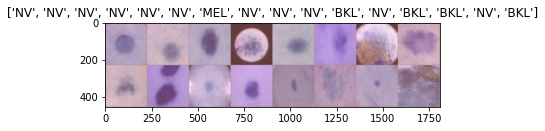

time: 878 ms (started: 2022-10-30 16:22:15 +00:00)


In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [11]:
model=models.resnet50(pretrained=False)
model.fc=nn.Sequential(nn.Linear(2048, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairresnet50/resnet50_wt_epoch_19_batch_78_auc_0.6407.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 6.26 s (started: 2022-10-30 16:22:16 +00:00)


In [12]:
class FusionMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype=int)

    def update(self, output, label):
        length = output.shape[0]
        for i in range(length):
            self.matrix[int(output[i]), int(label[i])] += 1

    def get_fusion_matrix(self):
        return self.matrix

    def get_rec_per_class(self):
        rec = np.array(
            [
                self.matrix[i, i] / self.matrix[:, i].sum()
                for i in range(self.num_classes)
            ]
        )
        rec[np.isnan(rec)] = 0
        return rec

    def get_pre_per_class(self):
        pre = np.array(
            [
                self.matrix[i, i] / self.matrix[i, :].sum()
                for i in range(self.num_classes)
            ]
        )
        pre[np.isnan(pre)] = 0
        return pre

    def get_accuracy(self):
        acc = (
            np.sum([self.matrix[i, i] for i in range(self.num_classes)])
            / self.matrix.sum()
        )
        return acc

    # convert multi-classification into binary classification tasks, and calculate the accuracy.
    def get_binary_accuracy(self, class_no):
        class_no = int(class_no)
        if class_no >= self.num_classes or class_no < 0:
            raise AttributeError(
                "Parameter class_no must less than the number of class.")

        error_num = 0
        for i in range(self.num_classes):
            error_num += self.matrix[i, class_no]
            error_num += self.matrix[class_no, i]
        error_num -= 2 * self.matrix[class_no, class_no]
        ok_num = self.matrix.sum() - error_num
        acc = ok_num / self.matrix.sum()
        return acc

    def get_balance_accuracy(self):
        rec = self.get_rec_per_class()
        bacc = np.mean(rec)
        return bacc

    def get_f1_score(self):
        recall = self.get_rec_per_class()
        precision = self.get_pre_per_class()
        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_score[np.isnan(f1_score)] = 0
        return np.mean(f1_score)

    def plot_confusion_matrix(self, normalize = False, cmap=plt.cm.Blues):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = self.matrix.T

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=np.arange(self.num_classes), yticklabels=np.arange(self.num_classes),
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return fig

time: 3.47 ms (started: 2022-10-30 16:22:22 +00:00)


In [13]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    fusion_matrix = FusionMatrix(8)
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)
    pred_lst2 = np.argmax(pred_lst, axis=1)
    gt_lst2 = np.argmax(gt_lst, axis=1)
    fusion_matrix.update(pred_lst2, gt_lst2)
    print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
    print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
    print("Balanced Accuracy")
    print(fusion_matrix.get_balance_accuracy())
    print("Confusion Matrix")
    print(fusion_matrix.plot_confusion_matrix())
    print("f1-score")
    print(fusion_matrix.get_f1_score())
    
    #roc_auc = get_roc_auc(pred_lst, gt_lst)
    #print(roc_auc)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    
    auc_lst=np.array(auc_lst)
    
    acc_lst=np.array(acc_lst)
    print("auc-list")
    print('\n')
    print(auc_lst)
    print("accuracy-list")
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print("mean-auc"+str(auc))
    print("mean-auc"+str(acc))
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 3.7 ms (started: 2022-10-30 16:22:22 +00:00)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.


sensitivity-[0.23157895 0.8864645  0.         0.         0.42105263 0.
 0.         0.        ]
specicivity-[0.38461538 0.6588785  0.         0.         0.21014493 0.
 0.         0.        ]
Balanced Accuracy
0.19238700949859858
Confusion Matrix
Figure(432x288)
f1-score
0.16567109965838078
auc-list


[0.66728604 0.84348896 0.66512066 0.50142442 0.62443701 0.5746167
 0.68808279 0.56180638]
accuracy-list


[0.82612782 0.74266917 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.6407828711468411
mean-auc0.9069548872180451


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


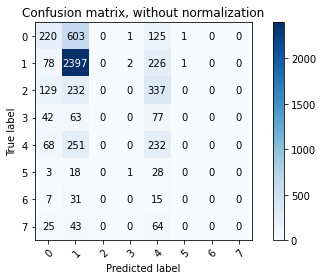

time: 31.8 s (started: 2022-10-30 16:22:22 +00:00)


In [14]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model)

In [15]:
model1=models.resnet50(pretrained=False)
model1.fc=nn.Sequential(nn.Linear(2048, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairresnet50/resnet50_wt_epoch_9_batch_78_auc_0.6426.pt')
model1.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 2.95 s (started: 2022-10-30 16:22:54 +00:00)


sensitivity-[0.36315789 0.91457101 0.         0.00549451 0.17422868 0.
 0.         0.        ]
specicivity-[0.3929385  0.6287821  0.         0.14285714 0.19123506 0.
 0.         0.        ]
Balanced Accuracy
0.18218151016057793
Confusion Matrix
Figure(432x288)
f1-score
0.1644495139807005
auc-list


[0.68525075 0.85851222 0.74977853 0.55748324 0.57535775 0.43993548
 0.6728903  0.59699905]
accuracy-list


[0.83383459 0.71823308 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.642025916405949
mean-auc0.9048637218045112


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


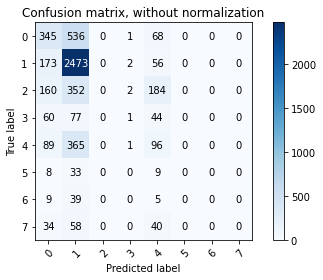

time: 16.6 s (started: 2022-10-30 16:22:57 +00:00)


In [16]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model1)

Computing Test Predictions


[0.66728604 0.84348896 0.66512066 0.50142442 0.62443701 0.5746167
 0.68808279 0.56180638]


[0.82612782 0.74266917 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
0.6407828711468411
0.9069548872180451


[0.68525075 0.85851222 0.74977853 0.55748324 0.57535775 0.43993548
 0.6728903  0.59699905]


[0.83383459 0.71823308 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
0.642025916405949
0.9048637218045112
auc-list


[0.70152884 0.86588266 0.75105203 0.55043225 0.61949356 0.49191271
 0.71148232 0.59680411]
accuracy-list


[0.83195489 0.73101504 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.6610735590129948
mean-auc0.9062265037593985
sensitivity-[0.33368421 0.92936391 0.         0.         0.2123412  0.
 0.         0.        ]
specicivity-[0.40228426 0.63491662 0.         0.         0.20454545 0.
 0.         0.        ]
Balanced Accuracy
0.18442366420923767
Confusion Matrix


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


Figure(432x288)
f1-score
0.16594820595294738


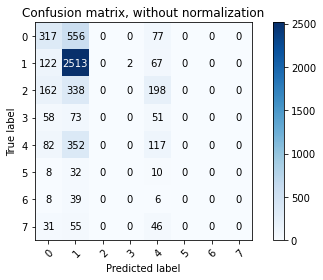

time: 31.8 s (started: 2022-10-30 16:23:14 +00:00)


In [17]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    pred_lst4=[]
    gt_lst4=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst4.append(outputs)
        gt_lst4.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst4, axis=0)
    gt_lst=np.concatenate(gt_lst4, axis=0)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    print('\n')
    print(auc_lst)
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print(auc)
    print(acc)
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

print('Computing Test Predictions')
auc1,acc1,pred_lst1,gt_lst1 = compute_predictions(model)
auc2,acc2,pred_lst2,gt_lst2 = compute_predictions(model1)

pred_lst = (pred_lst1+pred_lst2)/2
gt_lst = (gt_lst1+gt_lst2)/2
fusion_matrix = FusionMatrix(8)

auc_lst=[]
acc_lst=[]
for k in range(0,8):
    tmp_gt=gt_lst[:, k]
    tmp_pred=pred_lst[:,k]
    tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
    acc_lst.append(tmp_acc)
    tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
    auc_lst.append(tmp_auc)


auc_lst=np.array(auc_lst)

acc_lst=np.array(acc_lst)
print("auc-list")
print('\n')
print(auc_lst)
print("accuracy-list")
print('\n')
print(acc_lst)
auc=np.mean(auc_lst)
acc = np.mean(acc_lst)
print("mean-auc"+str(auc))
print("mean-auc"+str(acc))

#pred_lst=np.concatenate(pred_lst, axis=0)
#gt_lst=np.concatenate(gt_lst, axis=0)
pred_lst2 = np.argmax(pred_lst, axis=1)
gt_lst2 = np.argmax(gt_lst, axis=1)
fusion_matrix.update(pred_lst2, gt_lst2)
print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
print("Balanced Accuracy")
print(fusion_matrix.get_balance_accuracy())
print("Confusion Matrix")
print(fusion_matrix.plot_confusion_matrix())
print("f1-score")
print(fusion_matrix.get_f1_score())

#roc_auc = get_roc_auc(pred_lst, gt_lst)
#print(roc_auc)


In [18]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('../input/isiccsvfile/ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = '../input/pp2isic/preprocessed-segment/'+X_train['image']+ '.jpg'
X_test['image'] = '../input/pp2isic/preprocessed-segment/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
train_img_path = '../input/pp2isic/preprocessed-segment'


time: 674 ms (started: 2022-10-30 16:23:45 +00:00)


In [19]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 1.92 ms (started: 2022-10-30 16:23:46 +00:00)


In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)

image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=False, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 330 ms (started: 2022-10-30 16:23:46 +00:00)


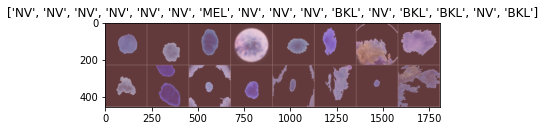

time: 831 ms (started: 2022-10-30 16:23:46 +00:00)


In [21]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [22]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    fusion_matrix = FusionMatrix(8)
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)
    pred_lst2 = np.argmax(pred_lst, axis=1)
    gt_lst2 = np.argmax(gt_lst, axis=1)
    fusion_matrix.update(pred_lst2, gt_lst2)
    print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
    print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
    print("Balanced Accuracy")
    print(fusion_matrix.get_balance_accuracy())
    print("Confusion Matrix")
    print(fusion_matrix.plot_confusion_matrix())
    print("f1-score")
    print(fusion_matrix.get_f1_score())
    
    #roc_auc = get_roc_auc(pred_lst, gt_lst)
    #print(roc_auc)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    
    auc_lst=np.array(auc_lst)
    
    acc_lst=np.array(acc_lst)
    print("auc-list")
    print('\n')
    print(auc_lst)
    print("accuracy-list")
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print("mean-auc"+str(auc))
    print("mean-auc"+str(acc))
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 2.12 ms (started: 2022-10-30 16:23:47 +00:00)


In [23]:
model=models.resnet50(pretrained=False)
model.fc=nn.Sequential(nn.Linear(2048, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairresnet50/resnet50_wt_epoch_19_batch_78_auc_0.6407.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 719 ms (started: 2022-10-30 16:23:47 +00:00)


sensitivity-[0.14947368 0.9785503  0.         0.         0.         0.
 0.         0.        ]
specicivity-[0.48630137 0.52625298 0.         0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.14100299750856432
Confusion Matrix
Figure(432x288)
f1-score
0.11413647447127731
auc-list


[0.61568385 0.62501845 0.45309821 0.4606637  0.45451683 0.33754839
 0.50132724 0.39102912]
accuracy-list


[0.82650376 0.48853383 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.47986072300732263
mean-auc0.875234962406015


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


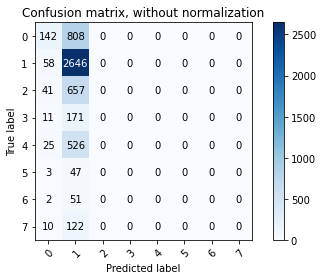

time: 24.6 s (started: 2022-10-30 16:23:48 +00:00)


In [24]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model)

In [25]:
model1=models.resnet50(pretrained=False)
model1.fc=nn.Sequential(nn.Linear(2048, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairresnet50/resnet50_wt_epoch_9_batch_78_auc_0.6426.pt')
model1.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model1.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

time: 754 ms (started: 2022-10-30 16:24:13 +00:00)


sensitivity-[0.99894737 0.00850592 0.         0.         0.         0.
 0.         0.        ]
specicivity-[0.17953084 0.67647059 0.         0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.12593166069760198
Confusion Matrix
Figure(432x288)
f1-score
0.04014529434172137
auc-list


[0.55231061 0.5865977  0.49936457 0.4622079  0.40504198 0.37344213
 0.51899868 0.36575299]
accuracy-list


[0.34398496 0.49210526 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.4704645679308387
mean-auc0.8153665413533835


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


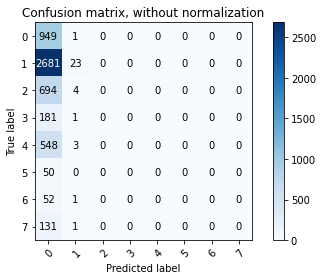

time: 15.9 s (started: 2022-10-30 16:24:14 +00:00)


In [26]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model1)

In [27]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    pred_lst4=[]
    gt_lst4=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst4.append(outputs)
        gt_lst4.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst4, axis=0)
    gt_lst=np.concatenate(gt_lst4, axis=0)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    print('\n')
    print(auc_lst)
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print(auc)
    print(acc)
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 2.43 ms (started: 2022-10-30 16:24:30 +00:00)


In [28]:
print('Computing Test Predictions')
auc1,acc1,pred_lst1,gt_lst1 = compute_predictions(model)
auc2,acc2,pred_lst2,gt_lst2 = compute_predictions(model1)

Computing Test Predictions


[0.61568385 0.62501845 0.45309821 0.4606637  0.45451683 0.33754839
 0.50132724 0.39102912]


[0.82650376 0.48853383 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
0.47986072300732263
0.875234962406015


[0.55231061 0.5865977  0.49936457 0.4622079  0.40504198 0.37344213
 0.51899868 0.36575299]


[0.34398496 0.49210526 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
0.4704645679308387
0.8153665413533835
time: 30.6 s (started: 2022-10-30 16:24:30 +00:00)


auc-list


[0.58083102 0.62527496 0.4965073  0.4616176  0.40588263 0.36857875
 0.51788459 0.36659774]
accuracy-list


[0.68139098 0.49229323 0.86879699 0.96578947 0.89642857 0.9906015
 0.99003759 0.97518797]
mean-auc0.47789682375586734
mean-auc0.8575657894736841
sensitivity-[0.94421053 0.0739645  0.         0.         0.         0.
 0.         0.        ]
specicivity-[0.18598383 0.40241449 0.         0.         0.         0.
 0.         0.        ]
Balanced Accuracy
0.1272718779196512
Confusion Matrix
Figure(432x288)
f1-score
0.05446474022684644


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


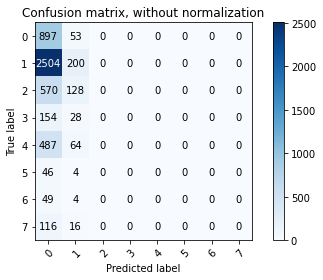

time: 482 ms (started: 2022-10-30 16:25:00 +00:00)


In [29]:
pred_lst = (pred_lst1+pred_lst2)/2
gt_lst = (gt_lst1+gt_lst2)/2
fusion_matrix = FusionMatrix(8)

auc_lst=[]
acc_lst=[]
for k in range(0,8):
    tmp_gt=gt_lst[:, k]
    tmp_pred=pred_lst[:,k]
    tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
    acc_lst.append(tmp_acc)
    tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
    auc_lst.append(tmp_auc)


auc_lst=np.array(auc_lst)

acc_lst=np.array(acc_lst)
print("auc-list")
print('\n')
print(auc_lst)
print("accuracy-list")
print('\n')
print(acc_lst)
auc=np.mean(auc_lst)
acc = np.mean(acc_lst)
print("mean-auc"+str(auc))
print("mean-auc"+str(acc))

#pred_lst=np.concatenate(pred_lst, axis=0)
#gt_lst=np.concatenate(gt_lst, axis=0)
pred_lst2 = np.argmax(pred_lst, axis=1)
gt_lst2 = np.argmax(gt_lst, axis=1)
fusion_matrix.update(pred_lst2, gt_lst2)
print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
print("Balanced Accuracy")
print(fusion_matrix.get_balance_accuracy())
print("Confusion Matrix")
print(fusion_matrix.plot_confusion_matrix())
print("f1-score")
print(fusion_matrix.get_f1_score())

#roc_auc = get_roc_auc(pred_lst, gt_lst)
#print(roc_auc)
